### Sentiment Analysis
Bidirectional LSTM with pre-trained GloVe embeddings.

IMDb dataset with 50k positive/negative reviews.

In [1]:
import numpy as np
import pandas as pd

reviews = pd.read_csv("/kaggle/input/imdb-dataset-of-50k-movie-reviews/IMDB Dataset.csv")
reviews.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [2]:
import re

def preprocess(text):
    text = text.lower()
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    words = text.split()
    words = [w for w in words if len(w) > 1]
    return words

reviews['preprocessed_review'] = reviews['review'].apply(preprocess)
reviews.head()

,review,sentiment,preprocessed_review
0,One of the other reviewers has mentioned that ...,positive,"[one, of, the, other, reviewers, has, mentione..."
1,A wonderful little production. <br /><br />The...,positive,"[wonderful, little, production, br, br, the, f..."
2,I thought this was a wonderful way to spend ti...,positive,"[thought, this, was, wonderful, way, to, spend..."
3,Basically there's a family where a little boy ...,negative,"[basically, theres, family, where, little, boy..."
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive,"[petter, matteis, love, in, the, time, of, mon..."


In [3]:
words = set()
for review in reviews['preprocessed_review']:
    words.update(review)
words = list(words)
vocab_size = len(words) + 1

vocab_size

175866

In [4]:
word2vec = {}
with open('/kaggle/input/glove-global-vectors-for-word-representation/glove.6B.100d.txt', encoding='utf-8') as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        word2vec[word] = coefs

embed_dim = 100
embed_glove = np.zeros((vocab_size, embed_dim))
for i, word in enumerate(words):
    if word in word2vec:
        embed_glove[i] = word2vec[word]

embed_glove.shape

(175866, 100)

In [5]:
reviews['preprocessed_review'].apply(len).describe()

count    50000.000000
mean       219.384360
std        164.033914
min          4.000000
25%        119.000000
50%        164.000000
75%        266.000000
max       2370.000000
Name: preprocessed_review, dtype: float64

In [6]:
max_len = 219 # avg word count

X = np.zeros((len(reviews), max_len, embed_dim))
for i, review in enumerate(reviews['preprocessed_review']):
    for j, word in enumerate(review):
        if j == max_len:
            break
        if word in word2vec:
            X[i, j] = word2vec[word]

X.shape

(50000, 219, 100)

In [7]:
y = (reviews['sentiment'].values == 'positive').astype(int)

train_size = int(len(reviews)*.95)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

print(X_train.shape, X_test.shape)
print(X_train[0, 0])
print(y[0])

(47500, 219, 100) (2500, 219, 100)
[-0.22556999  0.49417999  0.48609999 -0.4332      0.13738     0.50616997
  0.26058     0.30103001 -0.091486    0.10876     0.30579999  0.051028
  0.22303     0.054236    0.068838   -0.24700999  0.32688999 -0.082203
 -0.28865999  0.3734      0.73803997 -0.040969    0.040201    0.11384
  0.69986999 -0.49744999 -0.06755    -0.42598999 -0.10725    -0.010697
 -0.01479     0.55975997  0.3064      0.053053    0.058034    0.32756001
 -0.37233001  0.46513     0.14285    -0.085003   -0.45475999  0.19773
  0.6383     -0.31147999  0.10858     0.31557     0.36682001 -0.35135001
 -0.48414001 -0.33234999 -0.33816001 -0.39678001  0.1908      1.3513
 -0.39043999 -2.87949991 -0.14275999 -0.087754    1.77129996  0.99331999
 -0.14128999  0.94388998  0.050897    0.47373     0.86387002 -0.16162001
  0.67198998  0.52344     0.14438    -0.055194   -0.34669    -0.20742001
  0.18907    -0.19845     0.34862     0.10121    -0.092119   -0.66258001
 -1.0582     -0.11803     0.7017

In [8]:
import tensorflow as tf
from keras.layers import LSTM, Dense, Input, Dropout, Bidirectional

embeddings = Input(shape=(max_len, embed_dim))
lstm = Bidirectional(LSTM(units=128, return_sequences=True))(embeddings)
dropout = Dropout(.5)(lstm)
lstm = Bidirectional(LSTM(units=128))(dropout)
output = Dense(units=1, activation='sigmoid')(lstm)

model = tf.keras.Model(inputs=embeddings, outputs=output)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

2024-04-01 06:22:41.137051: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-01 06:22:41.137162: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-01 06:22:41.252824: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 219, 100)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 219, 256)       │       234,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 219, 256)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ (None, 256)            │       394,240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 628,993 (2.40 MB)

 Trainable params: 628,993 (2.40 MB)

 Non-trainable params: 0 (0.00 B)

In [9]:
history = model.fit(X_train, y_train, epochs=10, batch_size=128, validation_data=(X_test, y_test))

Epoch 1/10
372/372 ━━━━━━━━━━━━━━━━━━━━ 36s 79ms/step - accuracy: 0.6616 - loss: 0.6123 - val_accuracy: 0.7060 - val_loss: 0.5777
Epoch 2/10
372/372 ━━━━━━━━━━━━━━━━━━━━ 28s 76ms/step - accuracy: 0.7788 - loss: 0.4751 - val_accuracy: 0.8280 - val_loss: 0.3945
Epoch 3/10
372/372 ━━━━━━━━━━━━━━━━━━━━ 28s 76ms/step - accuracy: 0.8311 - loss: 0.3876 - val_accuracy: 0.8416 - val_loss: 0.3619
Epoch 4/10
372/372 ━━━━━━━━━━━━━━━━━━━━ 28s 76ms/step - accuracy: 0.8492 - loss: 0.3458 - val_accuracy: 0.8096 - val_loss: 0.4117
Epoch 5/10
372/372 ━━━━━━━━━━━━━━━━━━━━ 28s 76ms/step - accuracy: 0.8616 - loss: 0.3271 - val_accuracy: 0.8568 - val_loss: 0.3396
Epoch 6/10
372/372 ━━━━━━━━━━━━━━━━━━━━ 28s 76ms/step - accuracy: 0.8662 - loss: 0.3100 - val_accuracy: 0.8588 - val_loss: 0.3195
Epoch 7/10
372/372 ━━━━━━━━━━━━━━━━━━━━ 28s 76ms/step - accuracy: 0.8781 - loss: 0.2834 - val_accuracy: 0.8652 - val_loss: 0.3056
Epoch 8/10
372/372 ━━━━━━━━━━━━━━━━━━━━ 28s 76ms/step - accuracy: 0.8896 - loss: 0.2616 - 

In [10]:
def test_reviews(reviews):
    processed_reviews = [preprocess(r) for r in reviews]
    filtered_reviews = [[word2vec[w] for w in r if w in word2vec] for r in processed_reviews]
    padded_reviews = [np.pad(r, ((0, max_len - len(r)), (0, 0))) for r in filtered_reviews]
    
    predictions = model.predict(np.array(padded_reviews))
    certainties = np.abs(predictions[:, 0] - 0.5) * 2
    sentiments = ['positive' if pred > 0.5 else 'negative' for pred in predictions]

    return zip(reviews, sentiments, certainties)

custom_reviews = ["I didn't like the movie!", "The movie was amazing!"]

results = test_reviews(custom_reviews)
for review, sentiment, certainty in results:
    print(review, sentiment, round(certainty, 2))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 318ms/step
I didn't like the movie! negative 0.37
The movie was amazing! positive 0.76


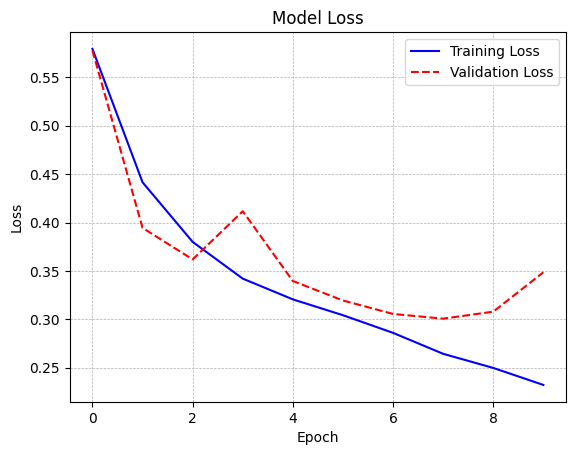

In [11]:
import matplotlib.pyplot as plt

plt.plot(history.history['loss'], color='blue', linestyle='-', label='Training Loss')
plt.plot(history.history['val_loss'], color='red', linestyle='--', label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.legend()
plt.show()